In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import skimage.io as io
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import os
from tqdm import tqdm
from glob import glob

In [31]:
#import image
train_path = 'image/'
tumor_label=pd.read_csv('label.csv')
img_size = 200
label = []
nub_train = len(glob(train_path + '/*.jpg'))
image_data = np.zeros((nub_train,img_size,img_size,3),dtype=np.uint8)

i = 0   
for img_path in tqdm(glob(train_path + '/*.jpg')):
    img = Image.open(img_path)
    img = img.resize((img_size,img_size)) 
    arr = np.asarray(img) 
    image_data[i, :, :, :] = arr 
    i += 1

for i in range(3000):
    data = tumor_label['label'][i]
    if data == 'no_tumor':
        label.append(0)
    else :
        label.append(1)    
    
    
image_data = np.array(image_data,dtype='float32')/255.0
label = np.array(label)

100%|██████████| 3000/3000 [00:11<00:00, 254.81it/s]


In [32]:
image_data.shape

(3000, 200, 200, 3)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(image_data, label, test_size=0.2, random_state=3)

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3)

In [35]:
#design the model
model = models.Sequential([
  layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', input_shape=(200, 200, 3)),
  layers.MaxPooling2D(pool_size=2),
  layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Flatten(),
  layers.Dense(units=128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(units=64, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation="sigmoid")
])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

In [36]:
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
57/57 [==============================] - 2s 25ms/step - loss: 0.4981 - accuracy: 0.8306 - val_loss: 0.3405 - val_accuracy: 0.8600
Epoch 2/20
57/57 [==============================] - 1s 24ms/step - loss: 0.3551 - accuracy: 0.8500 - val_loss: 0.2606 - val_accuracy: 0.8700
Epoch 3/20
57/57 [==============================] - 2s 28ms/step - loss: 0.2638 - accuracy: 0.8789 - val_loss: 0.2069 - val_accuracy: 0.9050
Epoch 4/20
57/57 [==============================] - 1s 23ms/step - loss: 0.2207 - accuracy: 0.8939 - val_loss: 0.1837 - val_accuracy: 0.9233
Epoch 5/20
57/57 [==============================] - 1s 23ms/step - loss: 0.1854 - accuracy: 0.9178 - val_loss: 0.1597 - val_accuracy: 0.9233
Epoch 6/20
57/57 [==============================] - 1s 23ms/step - loss: 0.1514 - accuracy: 0.9372 - val_loss: 0.1528 - val_accuracy: 0.9283
Epoch 7/20
57/57 [==============================] - 1s 23ms/step - loss: 0.1275 - accuracy: 0.9483 - val_loss: 0.1480 - val_accuracy: 0.9383
Epoch 8/20
57

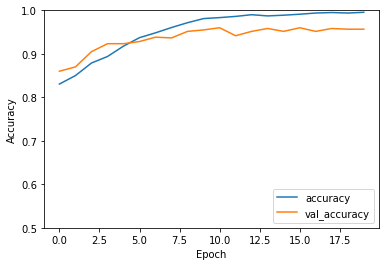

19/19 - 0s - loss: 0.1169 - accuracy: 0.9617


In [37]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [38]:
print(test_acc)

0.9616666436195374


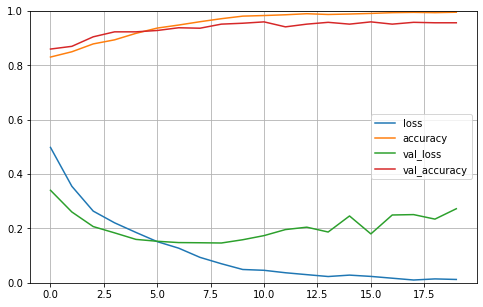

In [39]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()